https://docs.pymc.io/notebooks/GP-Latent.html

# Latent Variable Implementation

The `gp.Latent` class is a direct implementation of a GP. It is called "Latent" because the underlying function values are treated as latent variables. It has a prior method, and a `conditional` method. Given a mean and covariance function, the function $f(x)$ is modeled as,

$$f(x) \sim GP(m(x), k(x, x')$$

# Prior

With some data set of finite size, the prior method places a multivariate normal prior distribution on the vector of function values, f,

$$f \sim \text{MvNormal}(m_x, K_{xx})$$

where the vector $m$ and the matrix $K_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$. Some sample code is,

In [1]:
import numpy as np
import pymc3 as pm

# A one dimensional column vector of inputs
X = np.linspace(0, 1, 10)[:,None]

with pm.Model() as latent_gp_model:
    # Specify the covariance function
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)
    
    # Specify the GP. The default mean function is zero.
    gp = pm.gp.Latent(cov_func=cov_func)
    
    # Place a GP prior over the function f
    f = gp.prior('f', X=X)

By default, PyMC3 reparameterizes the prior on f under the hood by rotating it with the Cholesky factor of its covariance matrix. This helps to reduce covariances in the posterior of the transformed random variable, v. The reparameterized model is,

$$\begin{aligned}
v &\sim \mathcal{N}(0,1) \\
L &= Cholesky(K_{xx}) \\
f &= m_x + Lv
\end{aligned}$$

# Conditional

The conditional method implements the predictive distirbution for function values that were not part of the original data set. This distribution is,

$$f_* | f \sim \text{MvNormal}(m_* + K_{*x}K^ {-1}_{xx}f, K_{xx}-K_{*x}K^{-1}_{xx}K_{x*})$$

Using the same gp object we defined above, we can construct a random varaible with this distribution by

In [2]:
# Vector of X points we want to predict the function at
X_star = np.linspace(0, 2, 100)[:,None]

with latent_gp_model:
    f_star = gp.conditional('f_star', X_star)

# Example: Regression with Student-T distributed noise

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [5]:
import warnings

# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

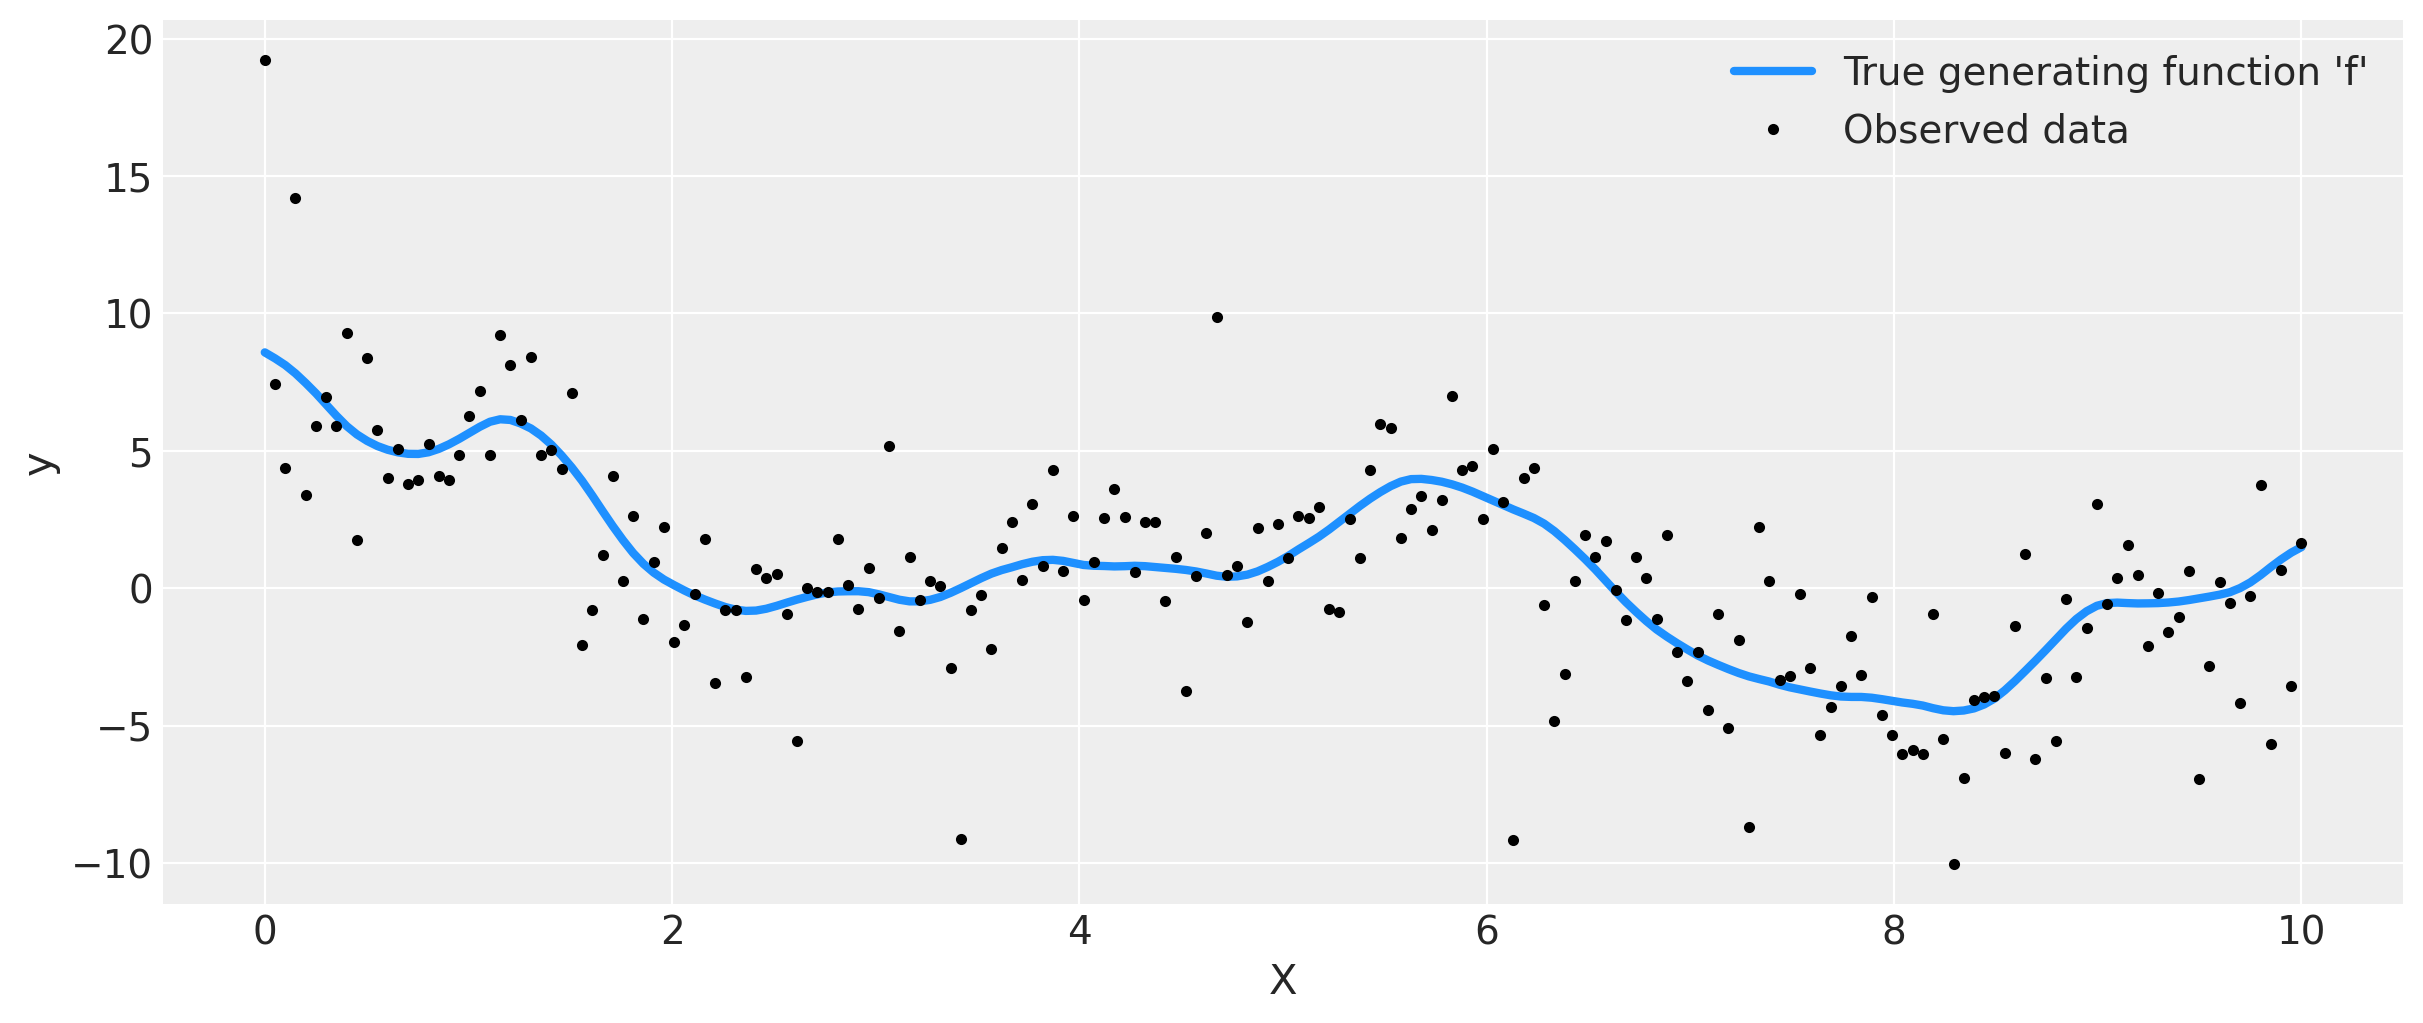

In [10]:
n = 200 # The number of data points
X = np.linspace(0, 10, n)[:,None] # The inputs to the GP must be column vectors


# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are on sample from a multivariate normal
# Note that we have to call 'eval()' beacause PyMC3 is built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
    ).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is 'sigma' and the degrees of freedom is 'nu'
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label='Observed data')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.legend();

The data above shows the observations, marked with black dots, of the unkown function $f(x)$ that has been corrupted by noise. The true function is in blue.

# Coding the model in PyMC3

Here is the model in PyMC3. We use a Gamma(2, 1) prior over the lengthscale parameter, and weakly informative HalfCauchy(5) priors over the covariance function scale and noise scale. A Gamma(2,0.1) prior is assigned to the degrees of freedom parameter of the noise. Finally, a GP prior is placed on the unknown function.

In [12]:
with pm.Model() as model:
    ℓ = pm.Gamma('l', alpha=2, beta=1)
    η = pm.HalfCauchy('η', beta=1)
    
    cov = η ** 2 * pm.gp.cov.Matern52(1,ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior('f', X=X)
    
    σ = pm.HalfCauchy('σ', beta=5)
    ν = pm.Gamma('ν', alpha=2, beta=0.1)
    y_ = pm.StudentT('y', mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains = 2, cores = 1, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 381 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
n_nonconverged = int(
    np.sum(az.rhat(trace)[['η', 'l', 'f_rotated_']].to_array() > 1.03))
print('%i variables MCMC chains appear not to have converged' % n_nonconverged)

0 variables MCMC chains appear not to have converged


# Results

Below is the joint posterior of the two covariance function hyperparameters. THe red lines show thte true values that were used to draw the function from the GP.

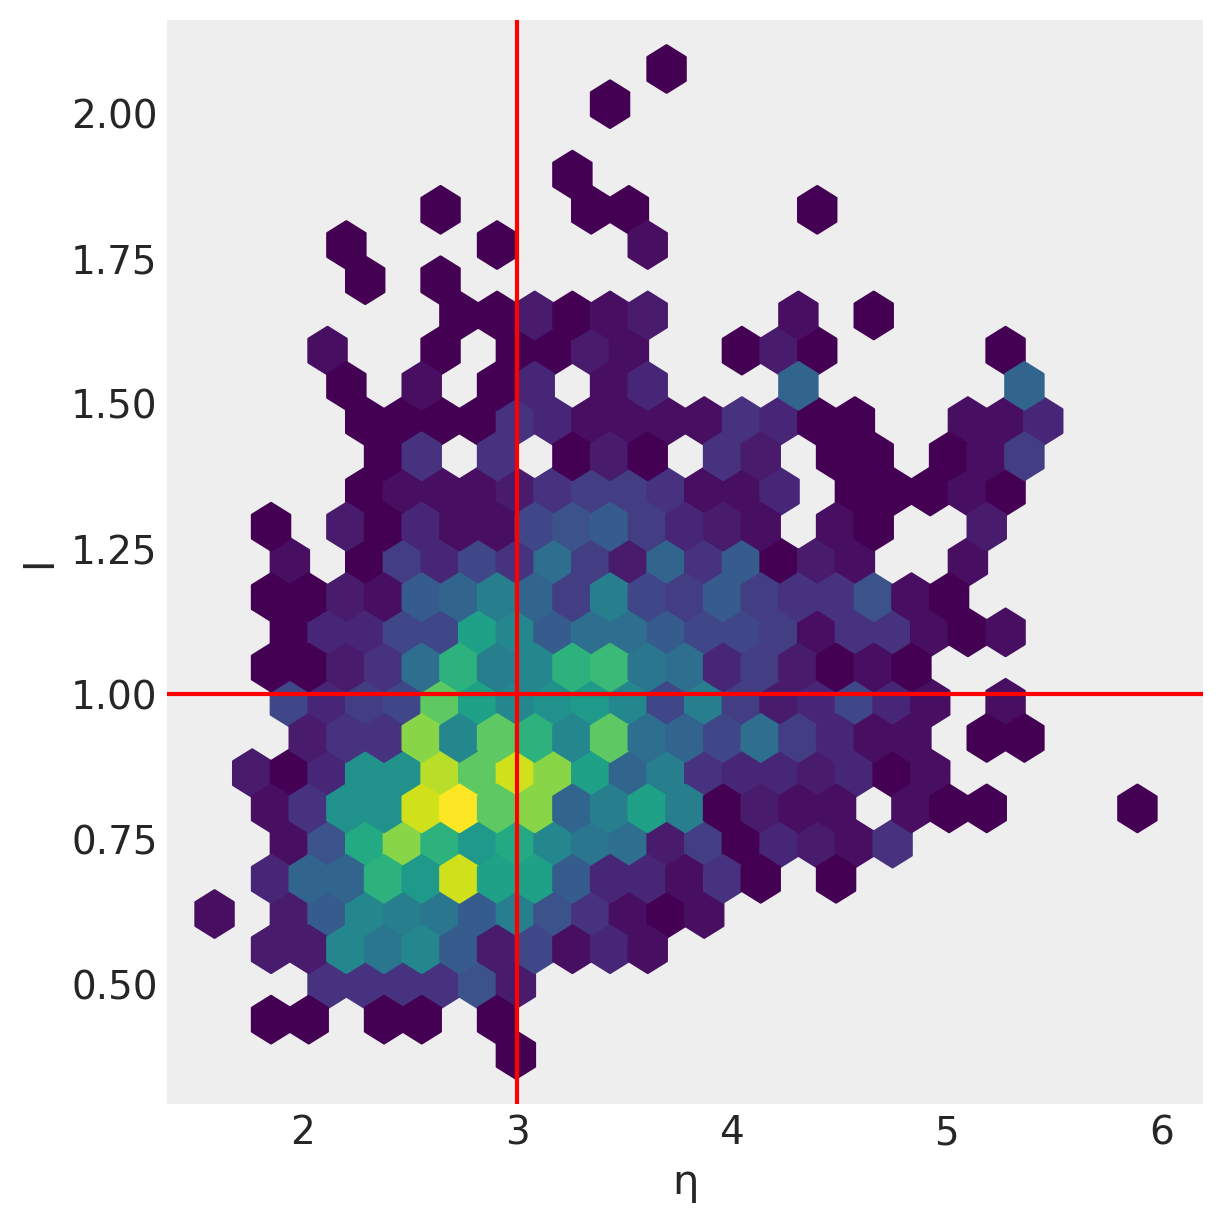

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

az.plot_pair(
    trace, var_names=['η', 'l'], kind=['hexbin'], ax=ax, gridsize=25, divergences=True)

ax.axvline(x = η_true, color='r')
ax.axhline(y = ℓ_true, color='r');

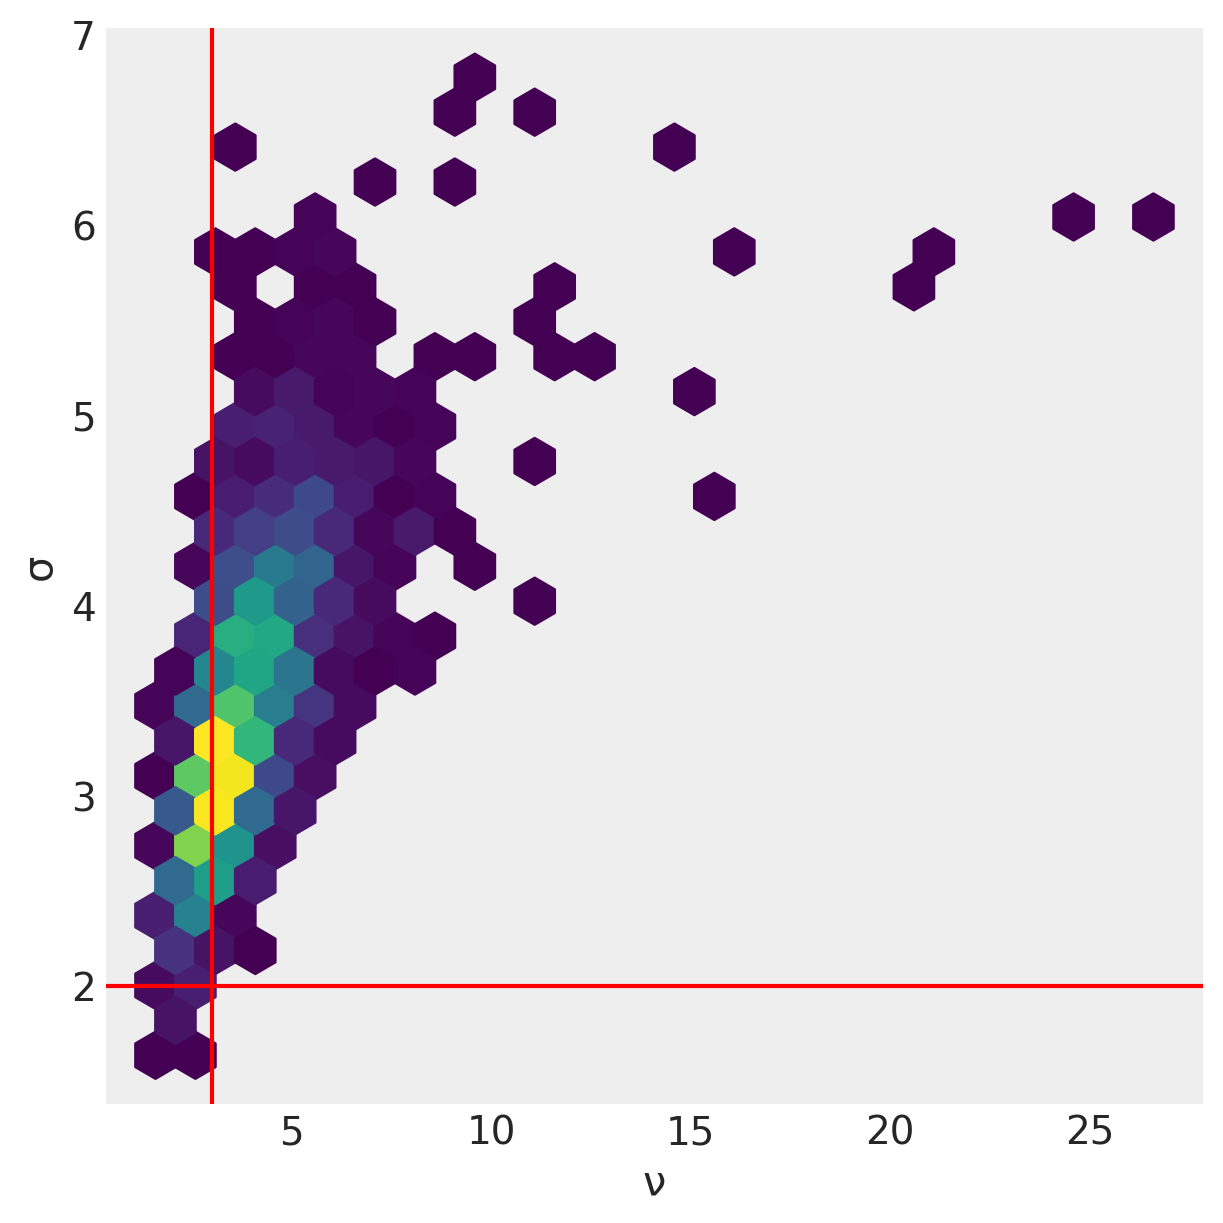

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

az.plot_pair(
    trace, var_names=["ν", "σ"], kind=["hexbin"], ax=ax, gridsize=25, divergences=True,
)

ax.axvline(x=ν_true, color="r")
ax.axhline(y=σ_true, color="r");

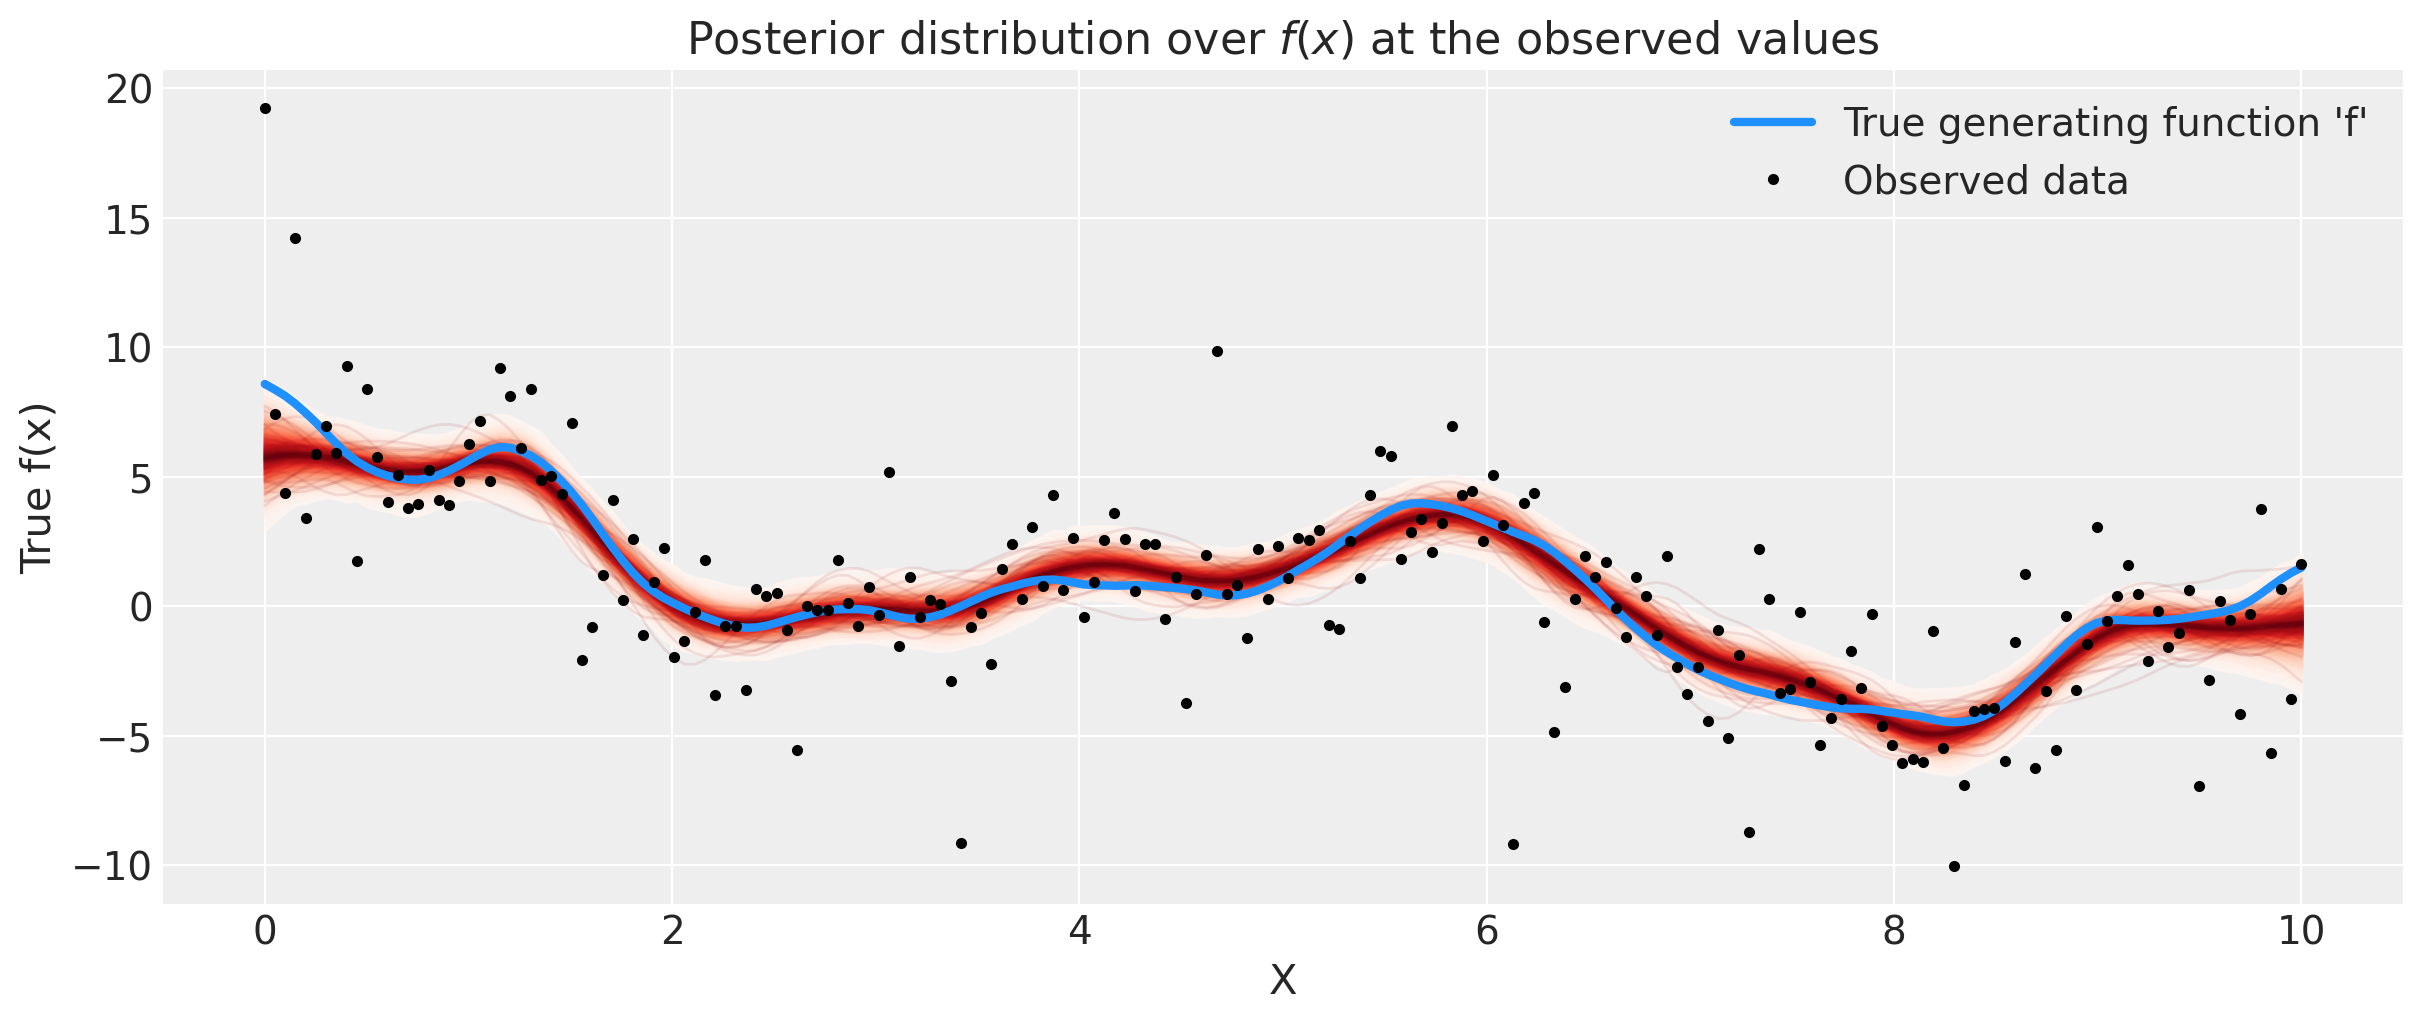

In [22]:
# Plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# Plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior['f'][0,:,:],X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit and the uncertainty caused by the additive noise. The result also doesn't over fit due to outliers from the StudenT noise model.

# Using conditional

Next, we extend the model by adding the conditional distribution so we can predict at new x locations. Lets see how the extrapolation looks out to higher x. To do this, we extend our model with the conditional distribution over the GP. Then, we can sample from it using the trace and the sample_posterior_predictive fucntion. This is similar to how Stan uses its generated quantities blocks. We could have included gp.conditional in the model before we did the NUTS sampling but it is more efficient to separate these steps.

In [15]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X vlaues
with model:
    f_pred = gp.conditional('f_pred', X_new)
    
# sample from the GP conditional dist
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])

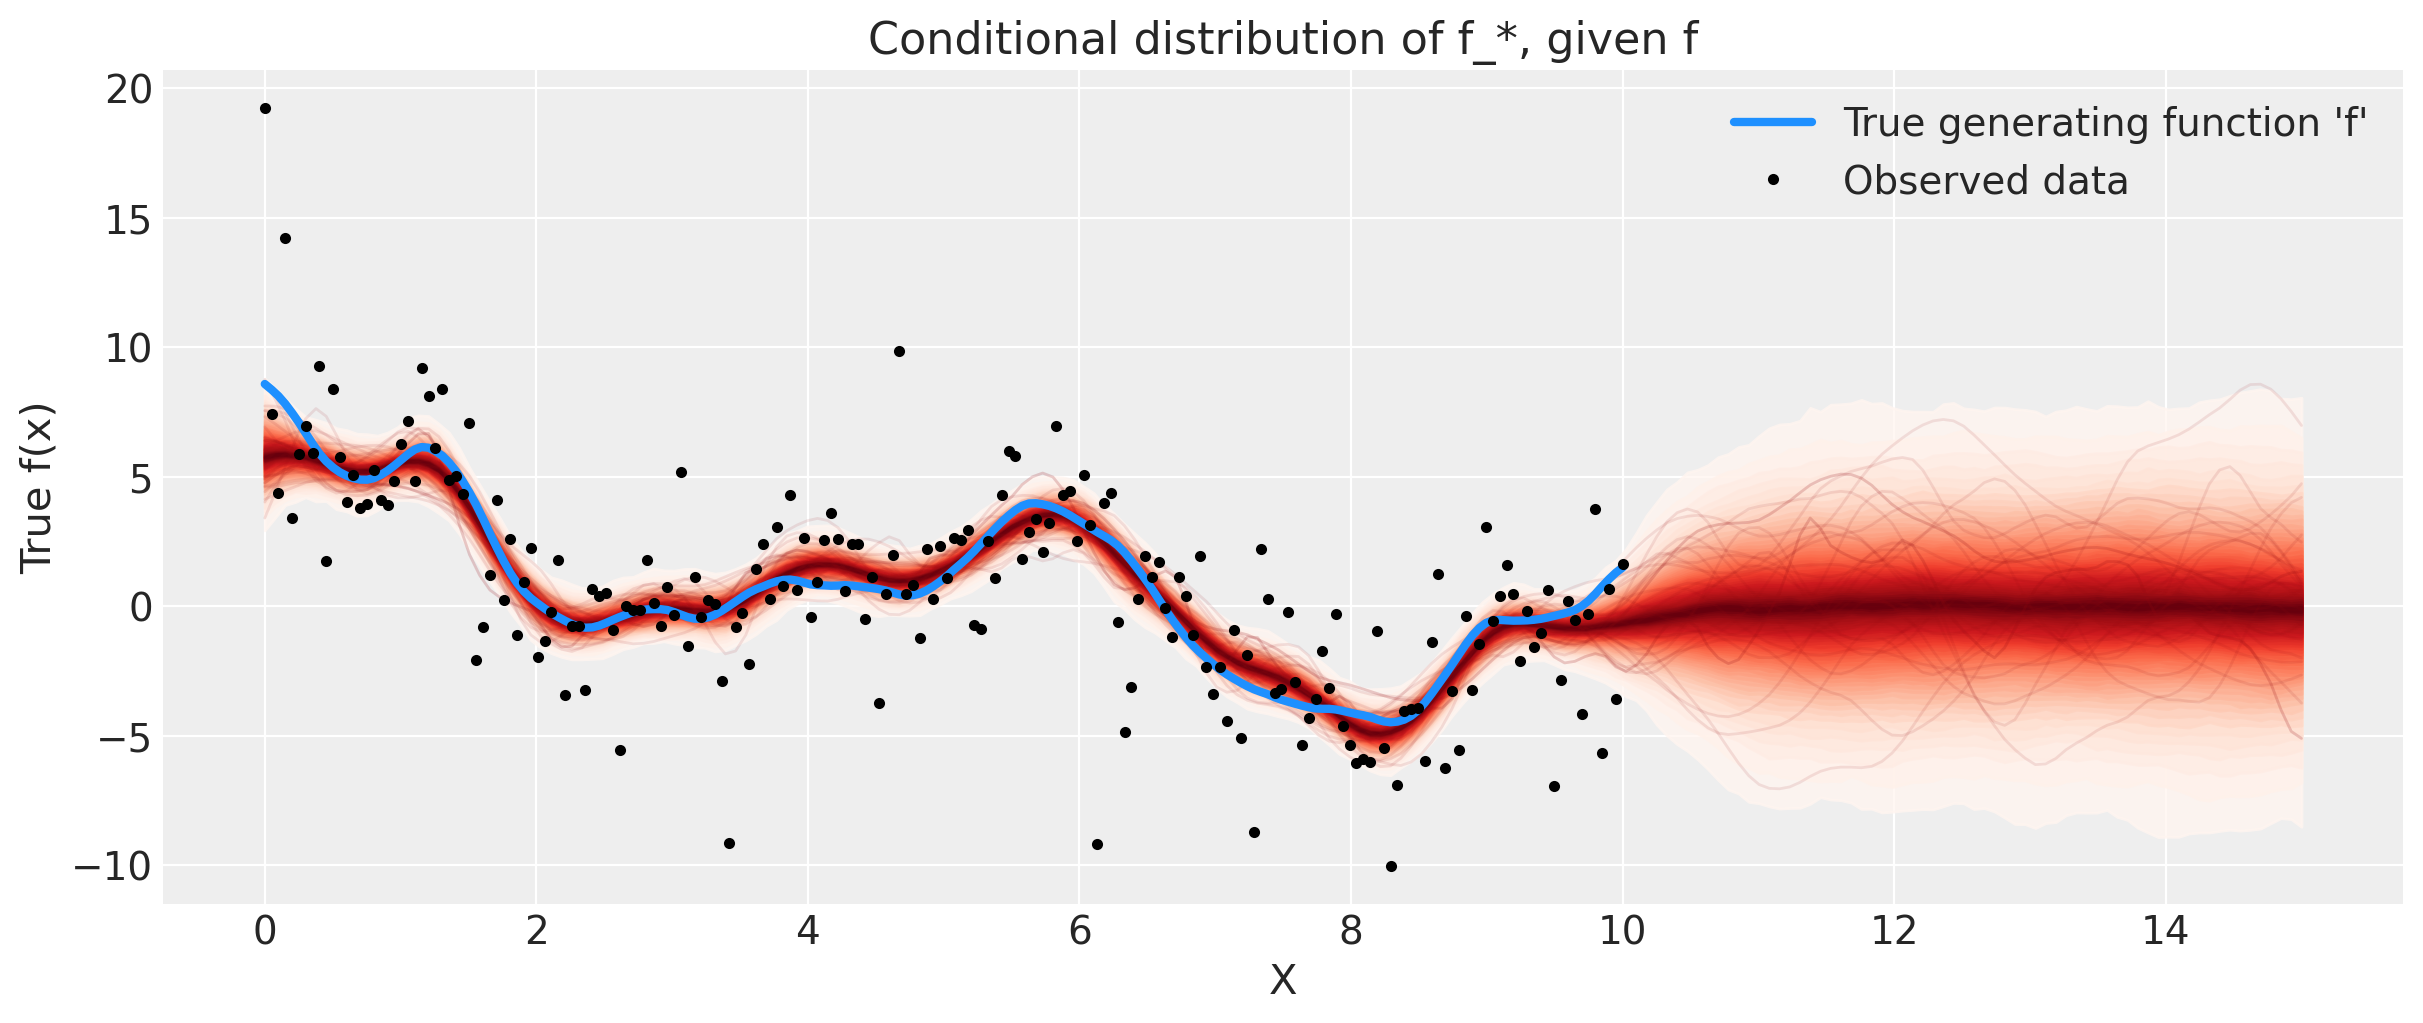

In [23]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();

# Testing with data with higher dimensions

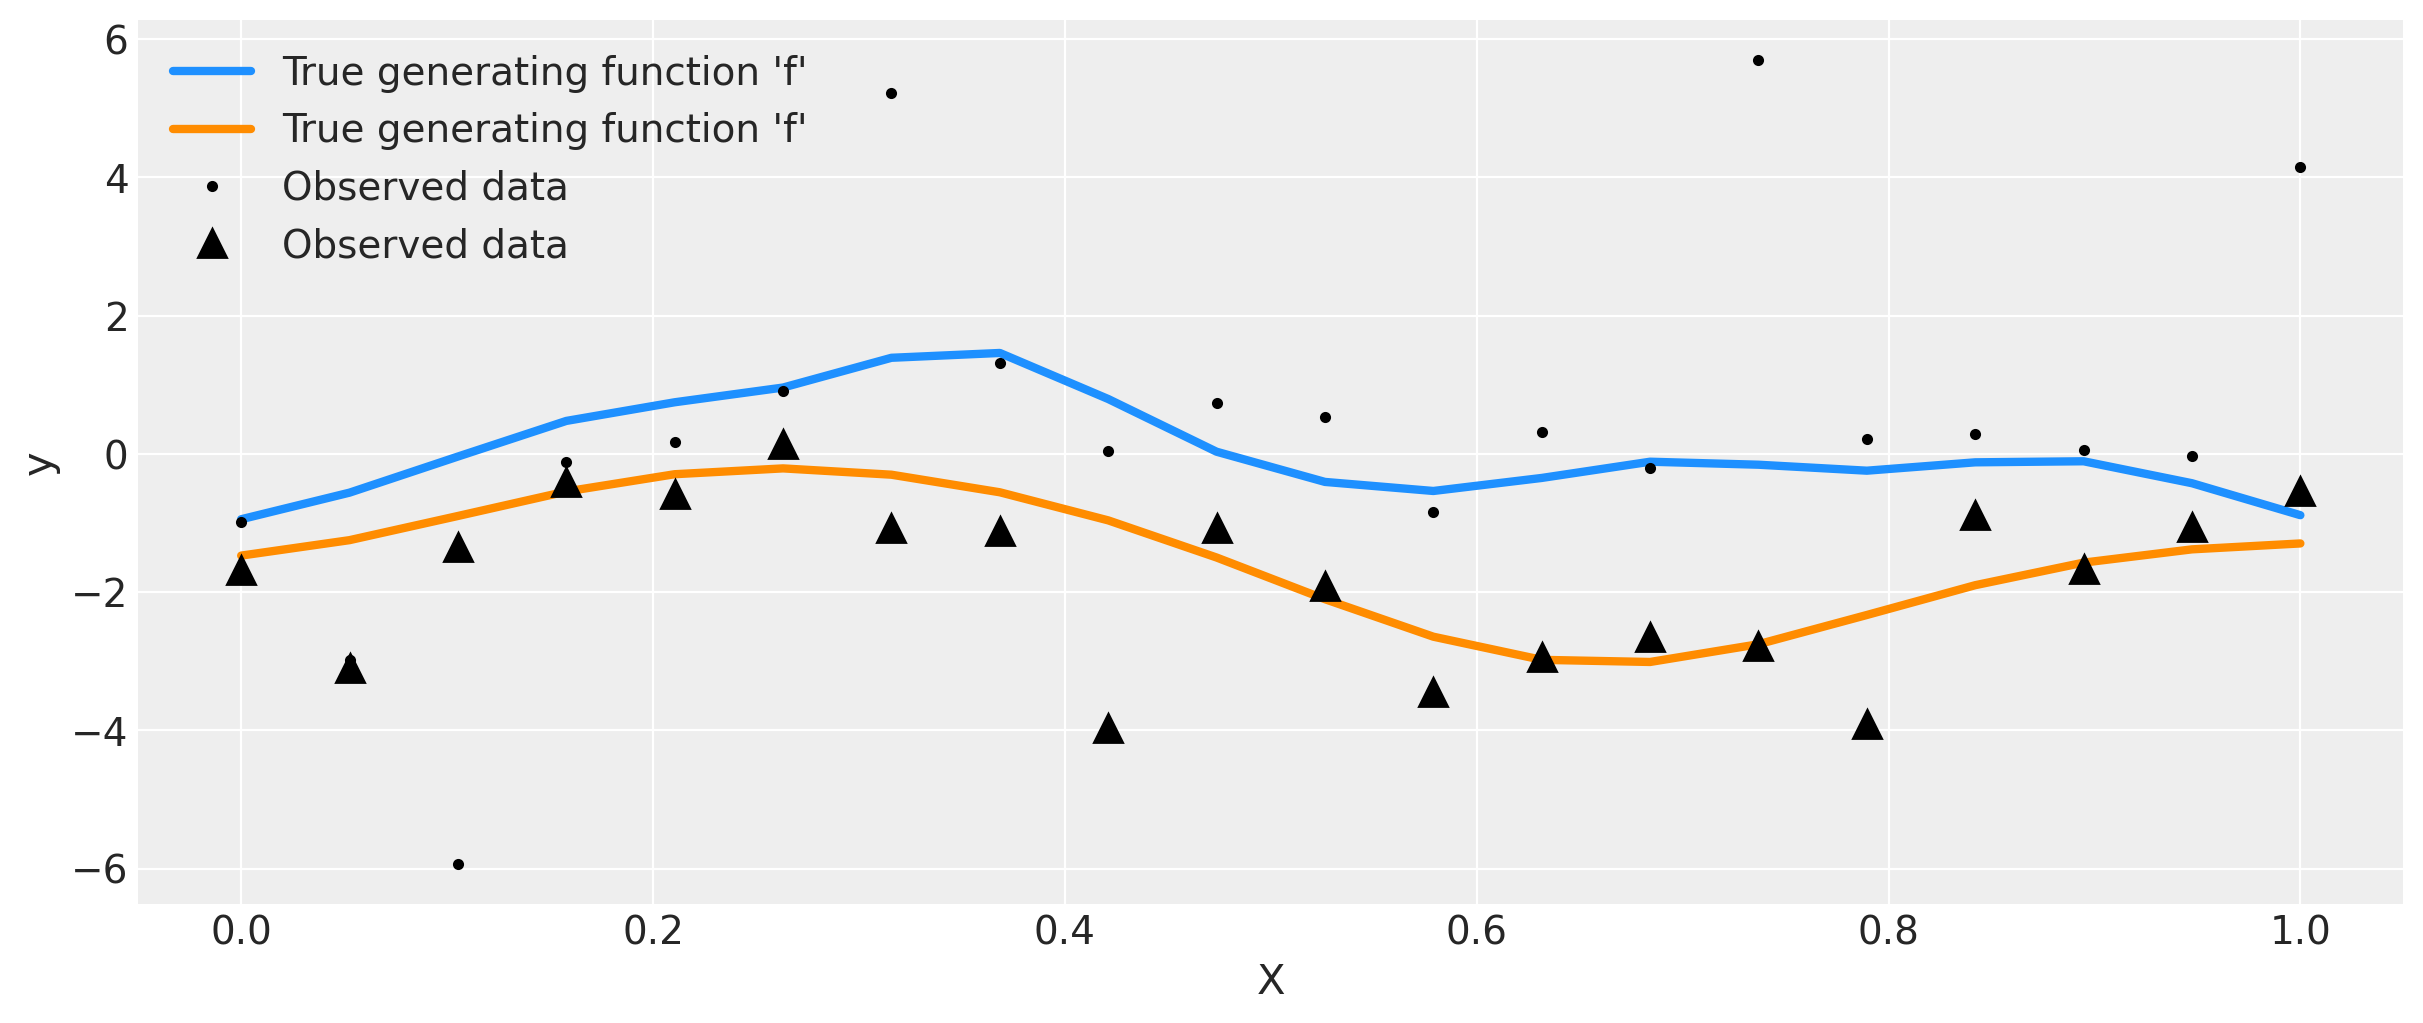

In [148]:
# One dimensional column vectors of inputs
X1 = np.linspace(0, 1, 20)[:, None]
X2 = np.linspace(0, 1, 20)[:, None]
n1 = X1.shape[0]
n2 = X2.shape[0]

Xs = [X1, X2]
# Specify the covariance functions for each Xi
cov_func1 = pm.gp.cov.ExpQuad(1, ls=0.1)  # Must accept X1 without error
cov_func2 = pm.gp.cov.ExpQuad(1, ls=0.2)  # Must accept X2 without error

# A mean function that is zero everywhere
mean_func1 = pm.gp.mean.Zero()
mean_func2 = pm.gp.mean.Zero()

# The latent function values are on sample from a multivariate normal
# Note that we have to call 'eval()' beacause PyMC3 is built on top of Theano
f_true1 = np.random.multivariate_normal(
    mean_func1(X1).eval(), cov_func1(X1).eval() + 1e-8 * np.eye(n1), 1
    ).flatten()
f_true2 = np.random.multivariate_normal(
    mean_func2(X2).eval(), cov_func2(X2).eval() + 1e-8 * np.eye(n2), 1
    ).flatten()

σ_true = 0.5
ν_true = 1.0
y1 = f_true1 + σ_true * np.random.standard_t(ν_true, size=n1)
y2 = f_true2 + σ_true * np.random.standard_t(ν_true, size=n2)
## plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X1, f_true1, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X2, f_true2, "darkorange", lw=3, label="True generating function 'f'")
ax.plot(X1, y1, "ok", ms=3, label='Observed data')
ax.plot(X2, y2, "ok",marker='^', ms=10, label='Observed data')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.legend();

In [154]:
X = np.tile(np.linspace(0, 1, 20)[:, None], (1,2))
y = np.concatenate((y1.reshape(-1,1), y2.reshape(-1,1)), axis=1)
with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(ls=[0.1,0.2], input_dim=2)
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy('σ', beta=5)
    ν = pm.Gamma('ν', alpha=2, beta=0.1)
    y_ = pm.StudentT('y', mu=f, lam=1.0 / σ, nu=ν, observed=y.T)

In [156]:
X_new = np.tile(np.linspace(0, 1, 25)[:, None], (1,2))

# add the GP conditional to the model, given the new X vlaues
with model:
    f_pred = gp.conditional('f_pred', X_new)
    
# sample from the GP conditional dist
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])

In [164]:
pred_samples['f_pred'].shape

(2000, 25)

ValueError: x and y must have same first dimension, but have shapes (20, 2) and (200,)

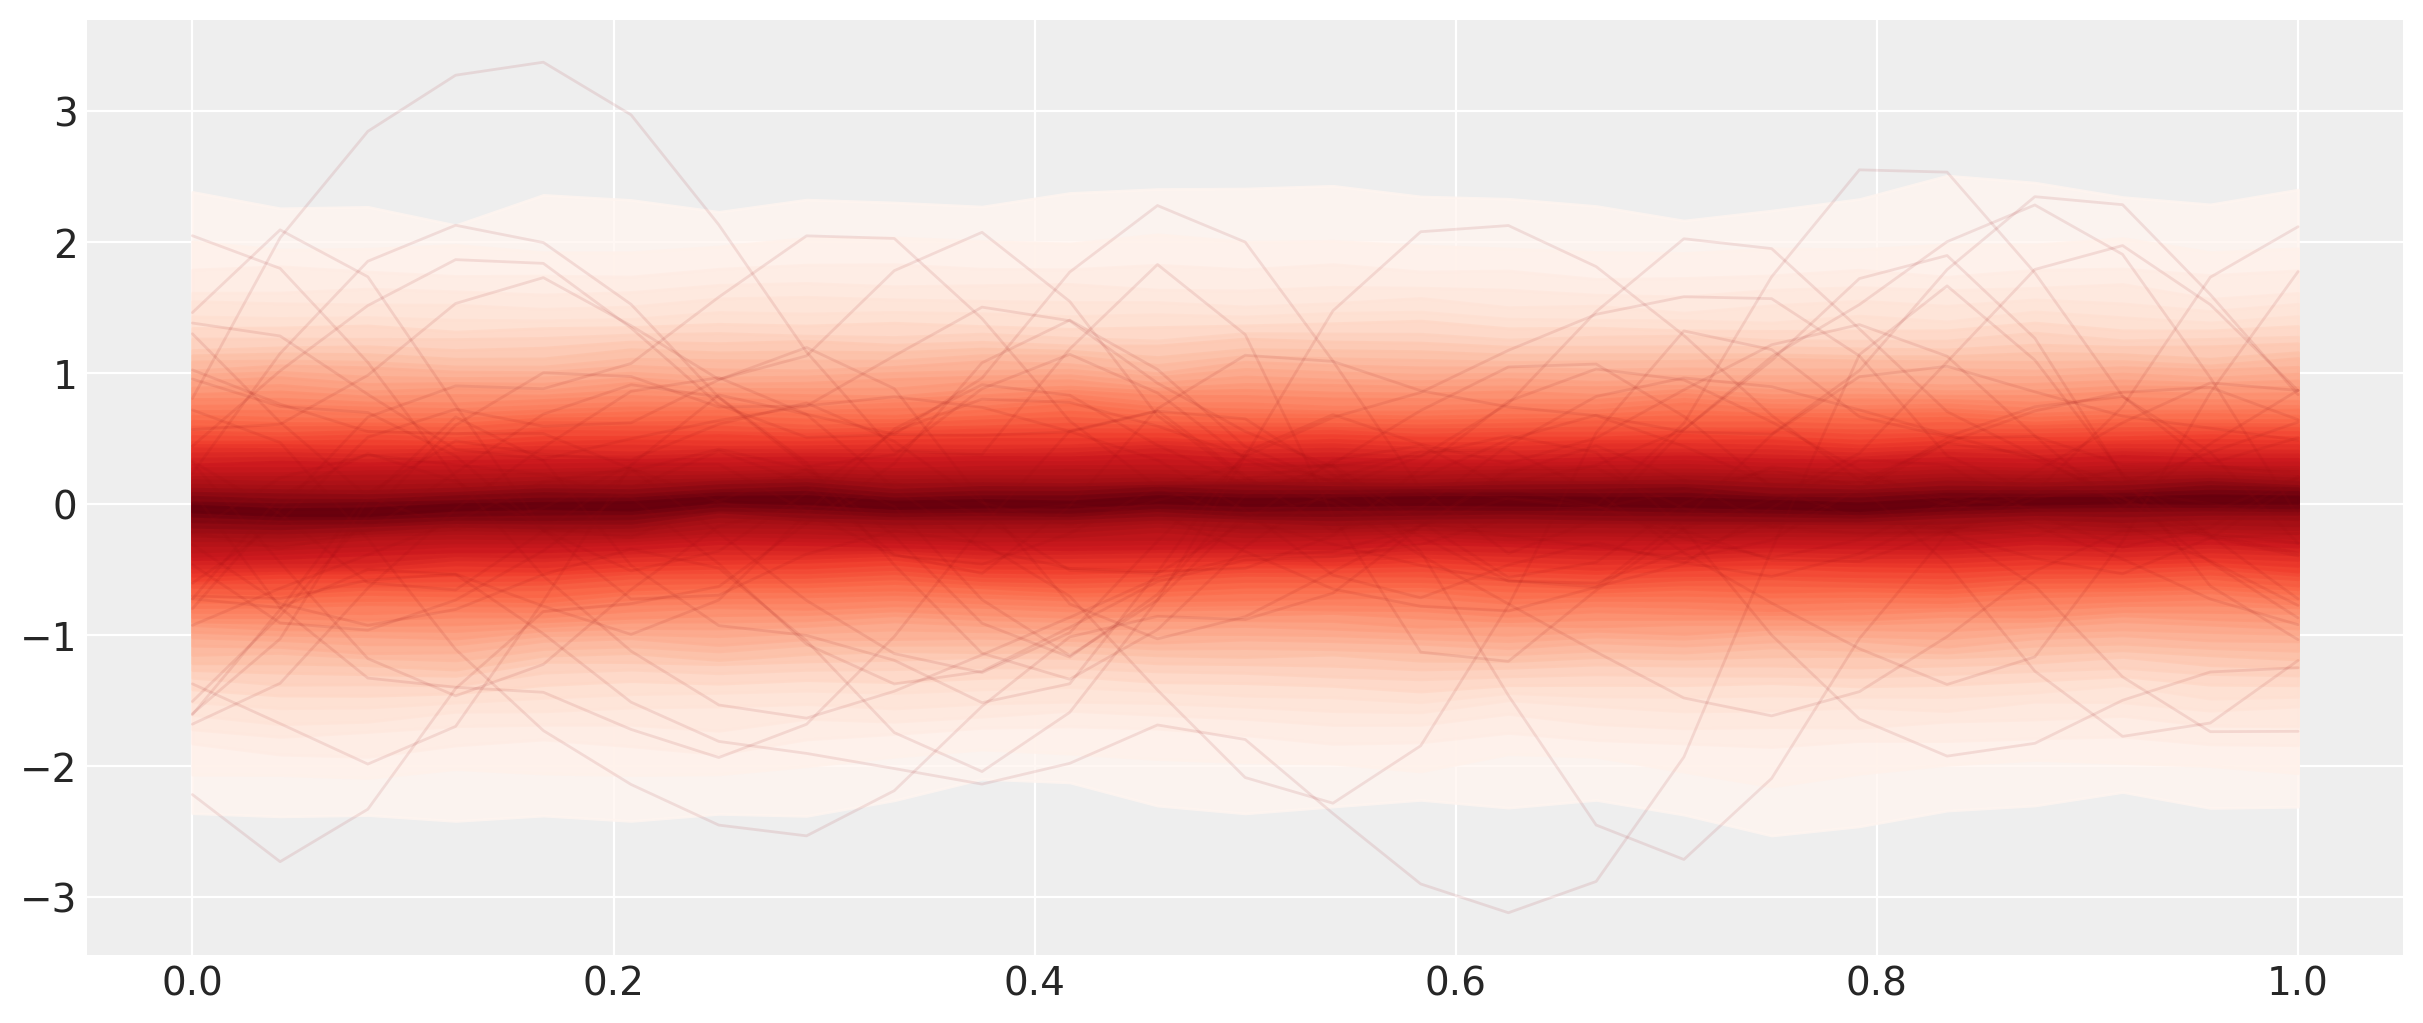

In [163]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new[:,0])
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();